In [44]:
import torch
import numpy as np
import scipy as sp
from scipy import signal

from _independent_component_analysis import SOBI, SlowFlows
from _flow_model import *
from _util import time_lagged_autocov
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%matplotlib inline

# Structural time series

### Data generation

In [2]:
import scipy as sp
from scipy import signal

np.random.seed(0)
n_samples = 4000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal

irregular_time = [0]
for _ in time[1:]:
    irregular_time.append(irregular_time[-1] + np.random.randint(5) + 1)
    
irregular_time = np.array(irregular_time) / n_samples * 8

s2 = np.sign(np.sin(3 * irregular_time))  # Signal 2 : square signal

irregular_time = [0]
for _ in time[1:]:
    irregular_time.append(irregular_time[-1] + np.random.randint(5) + 1)
    
irregular_time = np.array(irregular_time) / n_samples * 8

s3 = signal.sawtooth(2 * np.pi * irregular_time)  # Signal 3: saw tooth signal
s4 = np.arange(-1, 1, 2/n_samples)

S = np.c_[s1, s2, s3, s4]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
S = (S - S.min(axis=0, keepdims=True)) / (S.max(axis=0, keepdims=True) - S.min(axis=0, keepdims=True))  # Standardize data
# Mix data
A = np.array([[1, 1, 1, 1], [0.5, 2, 1.0, 0.5], [1.5, 1.0, 2.0, 1.5], [-0.5, 1, 0.2, 0.5]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

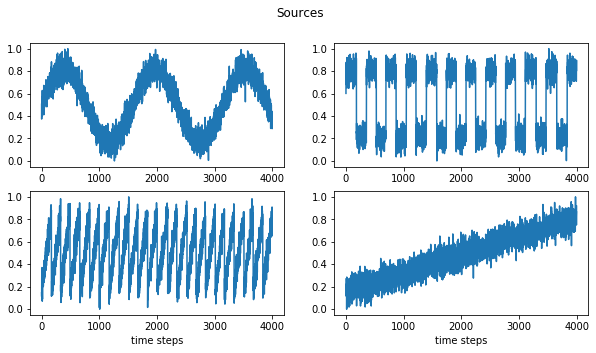

In [3]:
plt.figure(figsize=(10,5))
plt.suptitle('Sources')

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(S[:, i])
    if i>1:
        plt.xlabel('time steps')

### Non-linear mixing with a randomly initialized flow-based model

In [4]:
class FlowModel(LayerList, nn.Module):
    
    """ **FlowModel**: example of flow-based model architecture class.
    
        Parameters
        ----------
            * D: dimension of the input
            * NN: neural networks used in the **AffineCoupling**
            * depth: depth of the flow-based model (number of FlowLayers)
    """
    
    def __init__(self, D, NN, depth=1):
        super(FlowModel, self).__init__()
        self.D = D
        self.depth = depth
        
        layers = []
        for d in range(depth):
            shuffled_layer = Shuffle(D)
            layers.append(shuffled_layer)
            layers.append(ActivationNormalization(D))
            layers.append(AffineCoupling(D, NN()))
        
        layers.append(Prior(torch.zeros(1, D), torch.zeros(1, D)))
        self.layers = nn.ModuleList(layers)

In [19]:
S = torch.FloatTensor(S).to(device)
D = S.size(-1)
NN = lambda: nn.Sequential(nn.Linear(D//2, D))

mixture = FlowModel(D, NN, 10).to(device)

previous_loss = torch.zeros(S.size(0)).to(device)
    
X_nl = mixture.to_embedding(S, previous_loss)[0].unsqueeze(0).detach()

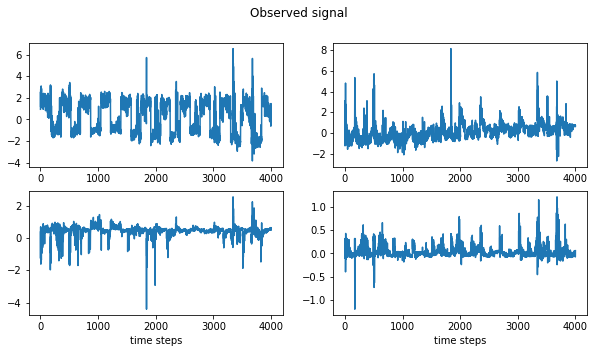

In [20]:
plt.figure(figsize=(10, 5));
plt.suptitle('Observed signal');
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(X_nl[0, :, i].cpu().detach().numpy())
    if i>1:
        plt.xlabel('time steps')

### Test linear ICA to see that it fails

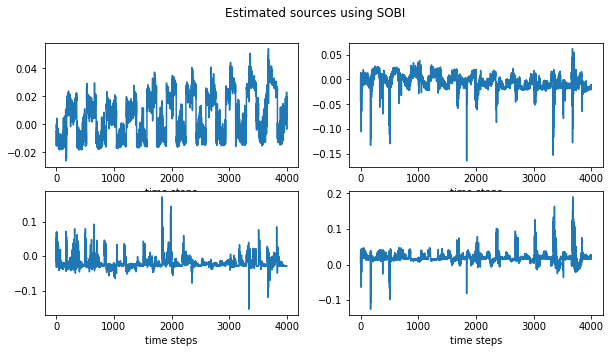

In [21]:
ica = SOBI(100)
S_estimated = ica.fit_transform(X_nl[0].cpu().detach().numpy())

plt.figure(figsize=(10, 5));
plt.suptitle('Estimated sources using SOBI');
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(S_estimated[:, i]);
    plt.xlabel('time steps')
    if i>1:
        plt.xlabel('time steps')

In [22]:
print('Mean max absolute correlation: {:.2f}'.format(np.abs(np.corrcoef(S.cpu().detach().numpy().T, S_estimated.T)[4:, :-4]).max(1).mean()))

Mean max absolute correlation: 0.43


We see that the mixing is effectively **not** linearly identifiable. 

### Unmixing with slow-FBM

We first define the flow-based unmixing model

In [23]:
class FlowModel(LayerList, nn.Module):
    
    """ **FlowModel**: example of flow-based model architecture class. """
    
    def __init__(self, D, NN, depth=1, trainable_variance=True):
        
        """ 
        
        Model initialization.
    
        Parameters
        ----------
            * D: dimension of the input
            * NN: neural networks used in the **AffineCoupling**
            * depth: depth of the flow-based model (number of FlowLayers)
            * trainable_variance: possibility to learn the variance parameters of the increment Gaussian distribution
                                  We remind that the theoretical results assume infinte data.
                                  In this toy example, we have not infinte data at all.
                                  The trainable variance for increment distribution gives more robust results in low data setup.
        """
        
        super(FlowModel, self).__init__()
        self.D = D
        self.depth = depth
        
        if trainable_variance:
            self.scales = nn.ParameterList([nn.Parameter(torch.ones(D), requires_grad=(i!=0)) for i in range(2)])
        else:
            self.scales = nn.ParameterList([nn.Parameter(torch.ones(D), requires_grad=False) for i in range(2)])
        
        layers = []
        for d in range(depth):
            shuffled_layer = Shuffle(D)
            layers.append(shuffled_layer)
            layers.append(ActivationNormalization(D))
            layers.append(AffineCoupling(D, NN()))
            layers.append(shuffled_layer)
            layers.append(ActivationNormalization(D))
            layers.append(AffineCoupling(D, NN()))
        
        layers.append(Linear(D))
        self.layers = nn.ModuleList(layers)

In [24]:
NN = lambda: nn.Sequential(nn.Linear(D//2, 16), nn.LeakyReLU(), 
                           nn.Linear(16, D))

flowModel = FlowModel(D, NN, 12)
flowModel = flowModel.to(device)

slow_flows = SlowFlows(D, flowModel)

In [25]:
slow_flows.fit(X_nl, batch_size=10, num_epochs=20)

iter 0: loss = 11.649
iter 10: loss = 18.122


The previous loss is specific to the Abstract Class design of the FlowBased model.

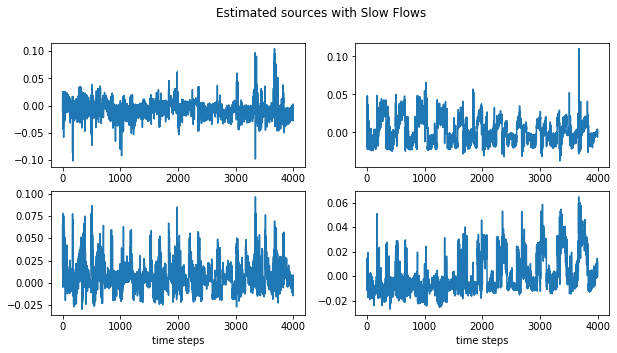

In [26]:
S_estimated = slow_flows.transform(X_nl)

corr = np.corrcoef(S.cpu().detach().numpy().T, S_estimated.T)[4:, :-4]
max_cor = np.argmax(np.abs(corr), axis=0)

plt.figure(figsize=(10,5))
plt.suptitle('Estimated sources with Slow Flows')
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(S_estimated[:, max_cor[i]])
    if i>1:
        plt.xlabel('time steps')

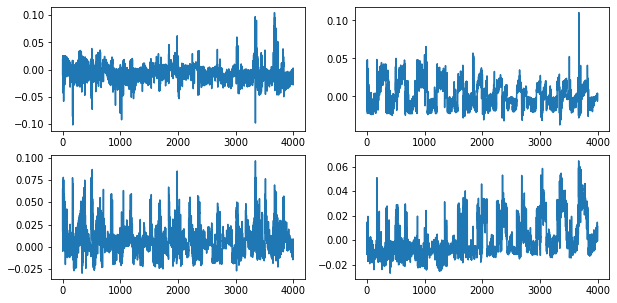

In [27]:
S_estimated = slow_flows.transform(X_nl)

corr = np.corrcoef(S.cpu().detach().numpy().T, S_estimated.T)[4:, :-4]
max_cor = np.argmax(np.abs(corr), axis=0)

plt.figure(figsize=(10,5))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(S_estimated[:, max_cor[i]])

In [28]:
print('Mean max absolute correlation: {:.2f}'.format(np.abs(np.corrcoef(S.cpu().detach().numpy().T, S_estimated.T)[4:, :-4]).max(1).mean()))

Mean max absolute correlation: 0.41


# Music

In [29]:
from scipy.io import wavfile
import copy

data_1 = copy.deepcopy(wavfile.read('/data/tsi/analyse_de_donnees/04-Data/Audio samples/sample_1.wav')[1][:, :1]).astype(float)
data_1 = (data_1 - data_1.min()) / (data_1.max() - data_1.min())
data_2 = copy.deepcopy(wavfile.read('/data/tsi/analyse_de_donnees/04-Data/Audio samples/sample_2.wav')[1][:, :1]).astype(float)
data_2 = (data_2 - data_2.min()) / (data_2.max() - data_2.min())
data_3 = copy.deepcopy(wavfile.read('/data/tsi/analyse_de_donnees/04-Data/Audio samples/sample_3.wav')[1][:, :1]).astype(float)
data_3 = (data_3 - data_3.min()) / (data_3.max() - data_3.min())
data_4 = copy.deepcopy(wavfile.read('/data/tsi/analyse_de_donnees/04-Data/Audio samples/sample_4.wav')[1][:, :1]).astype(float)
data_4 = (data_4 - data_4.min()) / (data_4.max() - data_4.min())

In [30]:
m = min(data_1.shape[0], data_2.shape[0], data_3.shape[0], data_4.shape[0])
S = np.concatenate([data_1[:m], data_2[:m], data_3[:m], data_4[:m]], axis=1)
S = S[range(0, S.shape[0], 5)]

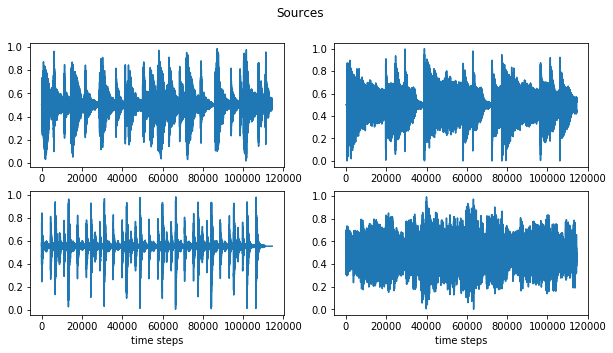

In [31]:
plt.figure(figsize=(10,5))
plt.suptitle('Sources')

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(S[:, i])
    if i>1:
        plt.xlabel('time steps')

### Non-linear mixing with a randomly initialized flow-based model

In [32]:
class FlowModel(LayerList, nn.Module):
    
    """ **FlowModel**: example of flow-based model architecture class.
    
        Parameters
        ----------
            * D: dimension of the input
            * NN: neural networks used in the **AffineCoupling**
            * depth: depth of the flow-based model (number of FlowLayers)
    """
    
    def __init__(self, D, NN, depth=1):
        super(FlowModel, self).__init__()
        self.D = D
        self.depth = depth
        
        layers = []
        for d in range(depth):
            shuffled_layer = Shuffle(D)
            layers.append(shuffled_layer)
            layers.append(ActivationNormalization(D))
            layers.append(AffineCoupling(D, NN()))
        
        layers.append(Prior(torch.zeros(1, D), torch.zeros(1, D)))
        self.layers = nn.ModuleList(layers)

In [33]:
S = torch.FloatTensor(S).to(device)
D = S.size(-1)
NN = lambda: nn.Sequential(nn.Linear(D//2, D))

mixture = FlowModel(D, NN, 10).to(device)

previous_loss = torch.zeros(S.size(0)).to(device)
    
X_nl = mixture.to_embedding(S, previous_loss)[0].unsqueeze(0).detach()

n_train = int(X_nl.size(1)*0.75)

X_nl_train = X_nl[:, :n_train]
X_nl_test = X_nl[:, n_train:]
S_train = S[:, :n_train]
S_test = S[:, n_train:]

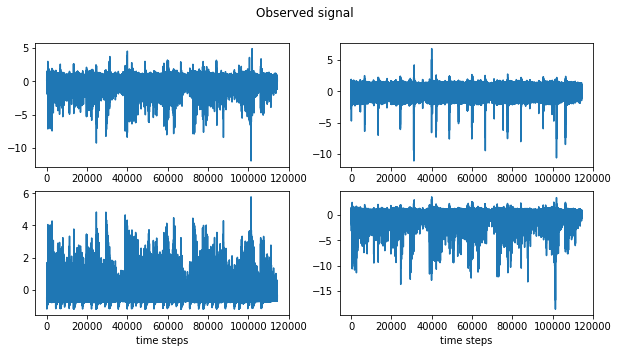

In [34]:
plt.figure(figsize=(10, 5));
plt.suptitle('Observed signal');
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(X_nl[0, :, i].cpu().detach().numpy())
    if i>1:
        plt.xlabel('time steps')

### Test linear ICA to see that it fails

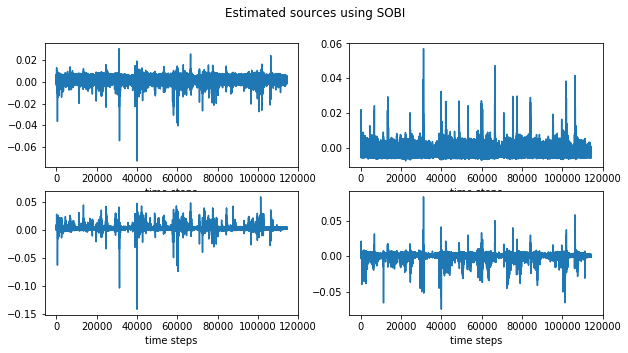

In [35]:
ica = SOBI(100)
S_estimated = ica.fit_transform(X_nl[0].cpu().detach().numpy())

plt.figure(figsize=(10, 5));
plt.suptitle('Estimated sources using SOBI');
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(S_estimated[:, i]);
    plt.xlabel('time steps')
    if i>1:
        plt.xlabel('time steps')

In [36]:
print('Mean max absolute correlation: {:.2f}'.format(np.abs(np.corrcoef(S.cpu().detach().numpy().T, S_estimated.T)[4:, :-4]).max(1).mean()))

Mean max absolute correlation: 0.40


We see that the mixing is effectively **not** linearly identifiable. 

### Unmixing with slow-FBM

We first define the flow-based unmixing model

In [37]:
class FlowModel(LayerList, nn.Module):
    
    """ **FlowModel**: example of flow-based model architecture class. """
    
    def __init__(self, D, NN, depth=1, trainable_variance=True):
        
        """ 
        
        Model initialization.
    
        Parameters
        ----------
            * D: dimension of the input
            * NN: neural networks used in the **AffineCoupling**
            * depth: depth of the flow-based model (number of FlowLayers)
            * trainable_variance: possibility to learn the variance parameters of the increment Gaussian distribution
                                  We remind that the theoretical results assume infinte data.
                                  In this toy example, we have not infinte data at all.
                                  The trainable variance for increment distribution gives more robust results in low data setup.
        """
        
        super(FlowModel, self).__init__()
        self.D = D
        self.depth = depth
        
        if trainable_variance:
            self.scales = nn.ParameterList([nn.Parameter(torch.ones(D), requires_grad=(i!=0)) for i in range(2)])
        else:
            self.scales = nn.ParameterList([nn.Parameter(torch.ones(D), requires_grad=False) for i in range(2)])
        
        layers = []
        for d in range(depth):
            shuffled_layer = Shuffle(D)
            layers.append(shuffled_layer)
            layers.append(ActivationNormalization(D))
            layers.append(AffineCoupling(D, NN()))
            layers.append(shuffled_layer)
            layers.append(ActivationNormalization(D))
            layers.append(AffineCoupling(D, NN()))
        
        layers.append(Linear(D))
        self.layers = nn.ModuleList(layers)

In [38]:
NN = lambda: nn.Sequential(nn.Linear(D//2, 16), nn.LeakyReLU(), nn.Linear(16, D))

flowModel = FlowModel(D, NN, 12)
flowModel = flowModel.to(device)

slow_flows = SlowFlows(D, flowModel)

In [39]:
slow_flows.fit(X_nl_train, num_epochs=20)

iter 0: loss = 12.706
iter 10: loss = 18.167


The previous loss is specific to the Abstract Class design of the FlowBased model.

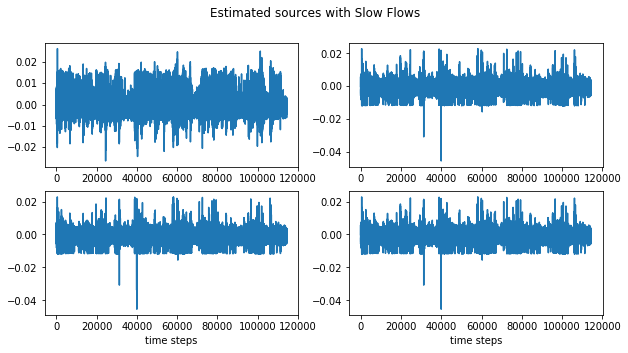

In [43]:
S_estimated = slow_flows.transform(X_nl)

corr = np.corrcoef(S.cpu().detach().numpy().T, S_estimated.T)[4:, :-4]
max_cor = np.argmax(np.abs(corr), axis=0)

plt.figure(figsize=(10,5))
plt.suptitle('Estimated sources with Slow Flows')
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(S_estimated[:, max_cor[i]])
    if i>1:
        plt.xlabel('time steps')

In [41]:
print('Mean max absolute correlation: {:.2f}'.format(np.abs(np.corrcoef(S.cpu().detach().numpy().T, S_estimated.T)[4:, :-4]).max(1).mean()))

Mean max absolute correlation: 0.32
